## Nibe pi LSTM network
Reads data from HA database and trains a LSTM net

### Python's SQLite3 support


This access method is very simple and perfect if you want to have a quick look at your data.

In [7]:
import sqlite3
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import pytz
from pytz import timezone
import copy
from math import sqrt
from pysolar.solar import *
import datetime

import sklearn as sk
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras import losses

In [63]:
import warnings
warnings.filterwarnings('ignore')

In [64]:
import mlflow.keras

mlflow.keras.autolog()
mlflow.set_tracking_uri('http://192.168.1.4:5000/')
mlflow.set_experiment("nibe")


In [65]:
latitude_deg = 55.6915 # positive in the northern hemisphere
longitude_deg = 13.230412 # negative reckoning west from prime meridian in Greenwich, England
futureSteps = 3
timestep = '60T'
scaler = sk.preprocessing.MinMaxScaler()

Create a connection to the database.

In [66]:
conn = sqlite3.connect('/home/homeassistant/.homeassistant/home-assistant_v2.db')

In [67]:
def getDataFrame(sensor, mean=False):
    df = pd.read_sql_query("SELECT state, last_changed FROM states WHERE entity_id = 'sensor." + sensor + "' AND state != 'unknown'", conn,index_col='last_changed', parse_dates=['last_changed'])
    df['state'] = df['state'].astype(float)
    if mean:
        df = df.resample(timestep).mean()
    else:
        df = df.resample(timestep).last()

    df = df.fillna(method='ffill')
    return df



In [68]:
#Group weathersymbols according to how much sun (yr.no)
def updateWeather(dfWeatherSymbol):
    resArray = []
    sunIcons = [[1],[2],[3,40,5,41,42,7,43,44,8,45,24,6,25,26,20,27,28,21,29],[10,11,12,13,14,15,22,23,30,31,32,33,34,46,47,48,49,50,4,9]]
    for icon in dfWeatherSymbol['state']:
        res = -1
        for i in range(4):
            if icon in sunIcons[i]:
                resArray.append(4-i)

    dfWeatherSymbol['state'] = resArray
    return dfWeatherSymbol

In [69]:
def getInitialDataFrame():
    dfIndoor = getDataFrame('downstairs_temperature')
    dfOutdoor = getDataFrame('outdoor_temperature')
    dfWeatherSymbol = updateWeather(getDataFrame('current_weather_symbol'))
    dfPercipitation = getDataFrame('current_weather_precipitation')
    dfWind = getDataFrame('current_weather_wind_speed')
    dfCalculatedSupply = getDataFrame('nibe_calculated_supply_temperature', mean=True)
    dfSupply = getDataFrame('nibe_supply_temperature', mean=True)
    dfReturn = getDataFrame('nibe_return_temperature', mean=True)
    dfDT = dfSupply['state'] - dfReturn['state']

    return pd.DataFrame({'Indoor':dfIndoor['state'],
            'IndoorDT':dfIndoor['state'].diff(),
            'Outdoor':dfOutdoor['state'],
            'Weather':dfWeatherSymbol['state'],
#            'Rain':dfPercipitation['state'],
#            'Wind':dfWind['state'],
            'CalculatedSupplyTemp':dfCalculatedSupply['state'],
            'SupplyTemp':dfSupply['state'],
            'dT':dfDT
           })


In [70]:
#Get sun radiation
def appendSolarFeature(df):
    stockholm = timezone('Europe/Stockholm')

    sunRadiationList = list()
    altitudeList = list()
    timeList = list()

    for date in df.index:
        localDate = stockholm.localize(date)
        altitude_deg = get_altitude(latitude_deg, longitude_deg, localDate)
        sunRadiationList.append(radiation.get_radiation_direct(date, altitude_deg))

        if altitude_deg < 0:
            altitude_deg = 0
        altitudeList.append(altitude_deg)
        
        seconds  = (localDate - localDate.replace(hour=0, minute=0, second=0, microsecond=0)).total_seconds()
        timeList.append(seconds)

    df['SunRadiation'] = sunRadiationList
    #df['SunAltitude'] =  altitudeList
    df['time'] = timeList
    return df

In [71]:
def appendWeatherForcast(df):
    dfTempForcastT1 = getDataFrame('weather_1_temperature')
    dfTempForcastT2 = getDataFrame('weather_2_temperature')
    dfTempForcastT3 = getDataFrame('weather_3_temperature')

    dfSymbolForcastT1 = updateWeather(getDataFrame('weather_1_symbol'))
    dfSymbolForcastT2 = updateWeather(getDataFrame('weather_2_symbol'))
    dfSymbolForcastT3 = updateWeather(getDataFrame('weather_3_symbol'))
    
    dfWindForecastT1 = getDataFrame('weather_1_wind_speed')
    dfWindForecastT2 = getDataFrame('weather_2_wind_speed')
        
    dataForecast = pd.DataFrame({
        'TempForcast1':dfTempForcastT1['state'],
        'TempForcast2':dfTempForcastT2['state'],
#        'TempForcast3':dfTempForcastT3['state'],
        'WeatherForcast1':dfSymbolForcastT1['state'],
        'WeatherForcast2':dfSymbolForcastT2['state'],
#        'WeatherForcast3':dfSymbolForcastT3['state']
        'WindForcast1':dfWindForecastT1['state'],
#        'WindForcast2':dfWindForecastT2['state']
    })

    df = pd.concat([dataForecast, df], axis=1)
    df = df.fillna(method='ffill')
    return df

In [72]:
def appendPrevious(df, column, steps = 2):
    for i in range(1, steps + 1):
        df[column + 'T-' + str(i)] = df[column].shift(i)
    return df

In [73]:
def appendFuture(df, column, steps = futureSteps):
    for i in range(1, steps + 1):
        df[column + 'T+' + str(i)] = df[column].shift(-i)
    return df

In [74]:
#Use to find features to remove
def findFeaturesToRemove(df):
    current = train(df, hidden=55, nepochs=135)
    print(current)
    while True:
        dropcol = ""
        newdf = copy.deepcopy(df)
        for col in newdf.columns[:-futureSteps]:
            testdf = copy.deepcopy(newdf)
            testdf.drop(columns=col)
            result = train(testdf, hidden=55, nepochs=135)
            print(col + " " + str(result))

            if result < current:
                current = result
                dropcol = col
                print("HIT!")

        print("---------------------\n" + str(current) + " " + dropcol)

        if dropcol == "":
            return newdf
        else:
            newdf.drop(columns=dropcol)

In [75]:
def splitData(df):
    x = df.values #returns a numpy array
    x_scaled = scaler.fit_transform(x)
    df = pd.DataFrame(x_scaled)

    # split into train and test sets
    values = df.values
    n_train_hours = int(len(values)*0.7)
    train = values[:n_train_hours, :]
    test = values[n_train_hours:, :]
    # split into input and outputs
    train_X, train_y = train[:, :-futureSteps], train[:, -futureSteps:]
    test_X, test_y = test[:, :-futureSteps], test[:, -futureSteps:]
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    return train_X, test_X, train_y, test_y

In [76]:
def makePrediction(model, test_x):
    # make a prediction
    yhat = model.predict(test_x)
    test_X2 = test_x.reshape((test_x.shape[0], test_x.shape[2]))

    # invert scaling for forecast
    inv_yhat = np.concatenate((test_X2, yhat), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)

    # invert scaling for actual
    test_y2 = test_y.reshape((test_y.shape[0], test_y.shape[1]))
    inv_y = np.concatenate((test_X2,test_y2), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    
    return inv_y, inv_yhat

In [77]:
def train(train_x, train_y, test_x, test_y, plot = False, hidden = 50, nepochs = 100, lr=0.0006):

    # design network
    model = Sequential()
    model.add(LSTM(hidden, input_shape=(train_x.shape[1], train_x.shape[2])))
#    model.add(LeakyReLU(alpha=0.5))
#    model.add(Dropout(0.05))
    model.add(Dense(futureSteps))

    adam = Adam(lr=lr)
    model.compile(loss='mae', optimizer=adam)
    
    # fit network
    es = EarlyStopping(monitor='val_loss', mode='min', patience=50, restore_best_weights=True)
    history = model.fit(train_x, train_y, epochs=nepochs, batch_size=32, validation_data=(test_x, test_y), verbose=0, shuffle=False, callbacks=[es])
    
    return model

RMSE: 0.2710939021696829
Mean absolute error: 0.21041087363448308


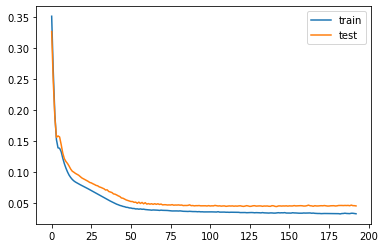

Text(0.5, 0, 'Hours since start')

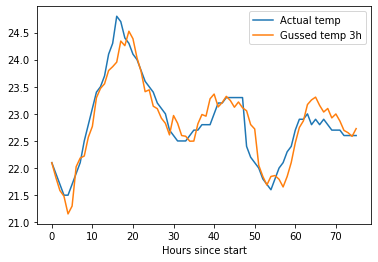

In [78]:
df = getInitialDataFrame()
df = appendSolarFeature(df)
df = appendPrevious(df, 'Indoor',3)
df = appendPrevious(df, 'IndoorDT',3)
df = appendPrevious(df, 'Outdoor',2)
df = appendPrevious(df, 'Weather',2)
df = appendPrevious(df, 'dT',2 )
df = appendWeatherForcast(df)
df = appendPrevious(df, 'CalculatedSupplyTemp',2)
df = appendFuture(df, 'CalculatedSupplyTemp', 2)
df = df.reindex(sorted(df.columns), axis=1)

#Indoor temp must be last, used for training
df = appendFuture(df, 'Indoor')

df = df.fillna(method='ffill')
df = df.dropna()

#Split data
train_x, test_x, train_y, test_y = splitData(df)

#df = findFeaturesToRemove(df)

model = train(train_x, train_y, test_x, test_y, plot=True, hidden=128, nepochs=1000, lr=0.0006)
inv_y, inv_yhat = makePrediction(model,test_x)

rmse = sqrt(mean_squared_error(inv_y[:,-1], inv_yhat[:,-1]))
   
print("RMSE: " + str(rmse))
print("Mean absolute error: " + str(mean_absolute_error(inv_y[:,-1], inv_yhat[:,-1])))

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

plt.plot(inv_y[:,-1], label='Actual temp')
plt.plot(inv_yhat[:,-1], label='Gussed temp 3h')
plt.legend()
plt.xlabel('Hours since start')


In [81]:

dfDiff = abs(df['Indoor'].diff(3)).dropna()
print('Average temp diff for 3 timesteps: \n' + str(dfDiff.mean()))

rmse = sqrt(mean_squared_error(np.ones(df['Indoor'].shape[0])*df['Indoor'].mean(), df['Indoor']))
print('\nRMSE from mean: \n' + str(rmse))

print("\nMean absolute error:\n" + str(mean_absolute_error(np.ones(df['Indoor'].shape[0])*df['Indoor'].mean(), df['Indoor'])))

Average temp diff for 3 timesteps: 
0.38559999999999994

RMSE from mean: 
0.7328208209847302

Mean absolute error:
0.5851145932603227
